In [15]:
import gym
import numpy as np
import gc
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
import random
import matplotlib.pyplot as plt

In [14]:
env = gym.make("FrozenLake-v1", map_name='8x8', is_slippery=False, new_step_api=False)
state = 0 # value between 0-63
state = np.identity(64)[state]
state = state.reshape(1,64)
state

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(64,)),
    tf.keras.layers.Dense(4, activation=None)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [17]:
gamma = 0.99
episodes = 500

In [18]:
def train(model, optimizer, states, actions, log_probs, rewards):
    T = len(rewards)
    rets = np.empty(T, dtype=np.float32) # the returns
    future_ret = 0.0
    # compute the returns efficiently
    for t in reversed(range(T)):
        future_ret = rewards[t] + gamma * future_ret
        rets[t] = future_ret
    rets = tf.convert_to_tensor(rets)
    log_probs = tf.convert_to_tensor(log_probs)
    with tf.GradientTape() as tape:
        pdparam = model(tf.convert_to_tensor(np.vstack(states), dtype=tf.float32))
        pd = tf.keras.activations.softmax(pdparam, axis=-1)
        selected_actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        selected_probs = tf.gather_nd(pd, tf.stack([tf.range(len(actions)), selected_actions], axis=-1))
        loss = -tf.reduce_sum(tf.math.log(selected_probs) * rets)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
Rewards = []

for epi in range(episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    states = []
    actions = []
    max_state = -1.0

    for t in range(200):
        state_one_hot = np.identity(64)[state]  # Convert state to one-hot encoded vector
        pdparam = model(np.expand_dims(state_one_hot, axis=0))
        pd = tf.keras.activations.softmax(pdparam, axis=-1)
        action = np.random.choice(range(pd.shape[1]), p=pd.numpy().ravel())
        log_prob = tf.math.log(pd[:, action])
        log_probs.append(log_prob)

        states.append(state_one_hot)
        actions.append(action)

        state, reward, done, _ = env.step(action)

        if state == 63:  # Goal state in FrozenLake 8x8 is 63
            reward = 1
            done = True
        else:
            reward = -0.1  # Negative reward for each step taken

        rewards.append(reward)

        if done:
            break

    loss = train(model, optimizer, np.vstack(states), actions, log_probs, rewards)
    total_reward = sum(rewards)
    Rewards.append(total_reward)

    print(f'Episode {epi+1}, total_reward: {total_reward}')

Episode 1, total_reward: -6.299999999999994
Episode 2, total_reward: -7.39999999999999
Episode 3, total_reward: -6.799999999999992
Episode 4, total_reward: -0.8999999999999999
Episode 5, total_reward: -4.999999999999998
Episode 6, total_reward: -0.9999999999999999
Episode 7, total_reward: -0.6
Episode 8, total_reward: -0.9999999999999999
Episode 9, total_reward: -2.2000000000000006
Episode 10, total_reward: -3.800000000000002
Episode 11, total_reward: -2.1000000000000005
Episode 12, total_reward: -4.6
Episode 13, total_reward: -4.899999999999999
Episode 14, total_reward: -2.500000000000001
Episode 15, total_reward: -0.7999999999999999
Episode 16, total_reward: -0.7
Episode 17, total_reward: -2.2000000000000006
Episode 18, total_reward: -3.3000000000000016
Episode 19, total_reward: -1.4000000000000001
Episode 20, total_reward: -5.699999999999996
Episode 21, total_reward: -2.2000000000000006
Episode 22, total_reward: -2.1000000000000005
Episode 23, total_reward: -2.400000000000001
Episod

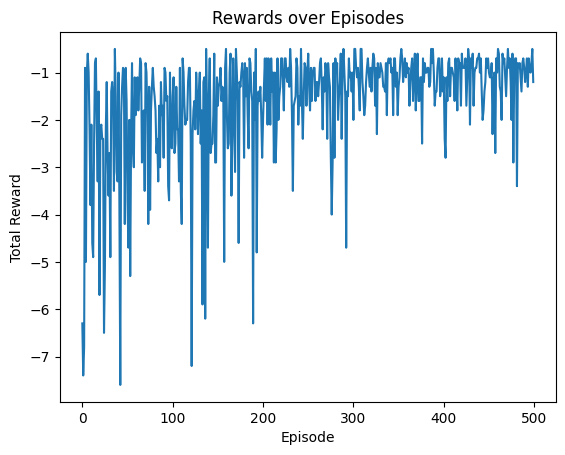

In [20]:
plt.plot(Rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()